In [1]:
import operator
import numpy as np
import pandas as pd
from scipy import sparse
import xgboost as xgb
from xgboost import XGBClassifier,XGBRegressor
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.linear_model import LinearRegression,LogisticRegression,LogisticRegressionCV

/home/jianqi/anaconda2/envs/xgboost/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from feature_extraction import *
from utils import *
from model import *

In [3]:
from scipy.sparse import hstack,csr_matrix
from collections import defaultdict
from scipy.stats import entropy
import cPickle

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def indicative_keyword(train_df_,test_df_,col,global_prob,minFreq=10,q=0.975,verbose=False):
    train_df = train_df_.copy()
    test_df = test_df_.copy()
    train_df[col] = train_df[col].map(lambda x:re.sub('\W',' ',x))
    train_df[col] = train_df[col].map(lambda x:' '.join(x.split()))
    test_df[col] = test_df[col].map(lambda x:re.sub('\W',' ',x))
    test_df[col] = test_df[col].map(lambda x:' '.join(x.split()))

    train_df['low'] = train_df['interest_level'].map(lambda x:int(x==0))
    train_df['medium'] = train_df['interest_level'].map(lambda x:int(x==1))
    train_df['high'] = train_df['interest_level'].map(lambda x:int(x==2))
    
    count_vect = CountVectorizer(ngram_range=(1,2),stop_words=None,min_df = minFreq)
    count_vect.fit(train_df[col])

    allpairs = {'key':[],'kl distance':[],'low':[],'medium':[],'high':[],'count':[]}
    for key,_ in count_vect.vocabulary_.iteritems():
        tmpdf = train_df[train_df[col].map(lambda x:key in x)]
        if len(tmpdf)<minFreq:
            if verbose:
                print 'cannot find {}'.format(key)
            continue
        p = np.array(tmpdf[['low','medium','high']].sum())*1./len(tmpdf)

        #similarity = np.sum(p*global_prob)
        kl_distance = entropy(p,global_prob)
        tmpdf_test = test_df[test_df[col].map(lambda x:key in x)]

        #if similarity < 0.3 and len(tmpdf_test)>minFreq:
        #    print 'key={}, length in test={}'.format(key,len(tmpdf_test))
        #    print 'kl distance={}'.format(kl_distance)
        #    print p
        if len(tmpdf_test)>minFreq and len(tmpdf)>minFreq:
            allpairs['key'].append(key)
            #allpairs['similarity'].append(similarity)
            allpairs['kl distance'].append(kl_distance)
            allpairs['low'].append(p[0])
            allpairs['medium'].append(p[1])
            allpairs['high'].append(p[2])
            allpairs['count'].append(len(tmpdf))
    allpairs = pd.DataFrame(allpairs)
    kl_quant = allpairs['kl distance'].quantile(q)
    allpairs = allpairs[allpairs['kl distance']>kl_quant]
    
    count_vect = CountVectorizer(ngram_range=(1,2),stop_words=None,vocabulary=list(allpairs['key']))
    trainX = count_vect.transform(train_df[col])
    #import pdb;pdb.set_trace()
    testX = count_vect.transform(test_df[col])
    return trainX,testX,allpairs

In [6]:
def normalize_fea(df,combined_fea,minFreq):    
    fea_list = []        
    all_fea = defaultdict(int)
    for _,row in df.iterrows():
        tmp = []
        for xx in row['features']:        
            theword = xx
            for kk,vv in combined_fea.iteritems():
                if xx in vv:
                    theword == kk
                    break
            tmp.append(theword)
            all_fea[theword] += 1
        fea_list.append(tmp)
    if len(fea_list)!=len(df):
        raise ValueError("length of two data do not match")
    df['features'] = fea_list
      
   
    
    fea_set = set()
    for kk,vv in all_fea.iteritems():
        if vv>minFreq:
            fea_set.add(kk)
    return df,fea_set            
            
def fea_col_proc(df_train_,df_test_,minFreq=10,q=0.9):    
    train_df = df_train_.copy() # Maybe ther eis better way to avoid SettingWithCopyWarning 
    test_df = df_test_.copy()
   
    #---------------------------
    #original length of the first feature, meant to capture those features typed in with wrong 
    # format -- all features are cramed into one phrase
    
    #-----------------------------
    
    def fea_clean(x): 
        if len(x) == 1:
            tmp = x[0].strip('*').split('*')
            if len(tmp) ==1:
                tmp = tmp[0].split(u'\u2022')
            x = tmp
        ret = [tt.encode('utf-8').decode('unicode_escape').encode('ascii','ignore').lower().strip() for tt in x]
        return ret
    train_df['features'] = train_df['features'].map(fea_clean)
    test_df['features'] = test_df['features'].map(fea_clean)
    
    combined_fea = {'laundry in unit':set(['laundry in unit','in-unit washer/dryer','washer & dryer',
                                    'washer/dryer','washer/dryer in unit']),
                    'laundry in building':set(['laundry in building','laundry room',
                                       'washer/dryer in building','on-site laundry']),
                   'gym/fitness':set(['gym/fitness','fitness center','gym','gym in building']),
                    'pre-war':set(['pre-war','prewar']),
                    'live-in superintendent':set(['live-in superintendent','live-in super','live in super']),
                    'hardwood floors':set(['hardwood floors','hardwood','hardwood floor','hardwood flooring']),
                    'high ceiling':set(['high ceiling','high ceilings']),
                    'full-time doorman':set(['full-time doorman','ft doorman','24/7 doorman','24 hour doorman',
                                        '24-hour doorman','24hr doorman','full time doorman','24 hr doorman'])
                   #'garage':['garage','parking']
                }
    
            
    train_df['low'] = train_df['interest_level'].map(lambda x:int(x==0))
    train_df['medium'] = train_df['interest_level'].map(lambda x:int(x==1))
    train_df['high'] = train_df['interest_level'].map(lambda x:int(x==2))
    
    train_df,tr_set = normalize_fea(train_df,combined_fea,minFreq)
    test_df,te_set = normalize_fea(test_df,combined_fea,minFreq)
    
    word_set = tr_set.union(te_set)
    
    global_prob = np.array(train_df['interest_level'].value_counts()*1./len(train_df))
    
    allpairs = {'key':[],'kl distance':[],'low':[],'medium':[],'high':[],'count':[]}
    for ww in word_set:
        tmpdf = train_df[train_df['features'].map(lambda x:ww in x)]
        p = np.array(tmpdf[['low','medium','high']].sum())*1.0/len(tmpdf)
        kl_distance = entropy(p,global_prob)
        allpairs['key'].append(ww)
            #allpairs['similarity'].append(similarity)
        allpairs['kl distance'].append(kl_distance)
        allpairs['low'].append(p[0])
        allpairs['medium'].append(p[1])
        allpairs['high'].append(p[2])
        allpairs['count'].append(len(tmpdf))
    allpairs = pd.DataFrame(allpairs)
    #import pdb;pdb.set_trace()
    allpairs = allpairs.sort_values('kl distance')
    allpairs.to_csv('features_col.csv',index=False)
    kl_quant = allpairs['kl distance'].quantile(q)
    allpairs = allpairs[allpairs['kl distance']>kl_quant]
    
    fealist = list(allpairs['key'])
    for ww in fealist:
        train_df[ww] = train_df['features'].map(lambda x:int(ww in x))
        test_df[ww] = test_df['features'].map(lambda x:int(ww in x))
    return train_df,test_df,fealist,allpairs


In [7]:
def id_features(train_df_,test_df_,col,minFreq=5,q=0.8):
    train_df = train_df_.copy() 
    test_df = test_df_.copy()
    
    #import pdb;pdb.set_trace()
    
    global_prob = np.array(train_df['interest_level'].value_counts()*1./len(train_df))
    sizename = col + '_size' 
    gp = train_df.groupby(col).size()
    gp.name = sizename
    train_df = train_df.merge(gp.reset_index(),how='left')
    
    tmpdf = train_df[train_df[sizename]>minFreq].copy()

    tmpdf['low'] = tmpdf['interest_level'].map(lambda x:int(x==0))
    tmpdf['medium'] = tmpdf['interest_level'].map(lambda x:int(x==1))
    tmpdf['high'] = tmpdf['interest_level'].map(lambda x:int(x==2))
    tmpdf['total'] = 1.

    tmpdf = tmpdf[[col,'low','medium','high','total']].groupby(col).sum()
    tmpdf['low'] = tmpdf['low']/tmpdf['total']
    tmpdf['high'] = tmpdf['high']/tmpdf['total']
    tmpdf['medium'] = tmpdf['medium']/tmpdf['total']

    allpairs = {'key':[],'kl distance':[],'low':[],'medium':[],'high':[],'count':[]}
    for m_id,row in tmpdf.iterrows():
        p = np.array(row[['low','medium','high']])
        kl_distance = entropy(p,global_prob)
        allpairs['key'].append(m_id)
            #allpairs['similarity'].append(similarity)
        allpairs['kl distance'].append(kl_distance)
        allpairs['low'].append(p[0])
        allpairs['medium'].append(p[1])
        allpairs['high'].append(p[2])
        allpairs['count'].append(row['total'])
    
    allpairs = pd.DataFrame(allpairs)
    allpairs = allpairs.sort_values('kl distance')
    allpairs.to_csv(col+'.csv',index=False)
    
    all_low = set(allpairs[allpairs['low']==1]['key'])
    train_df['all_low'] = train_df[col].map(lambda x:int(x in all_low))
    test_df['all_low'] = test_df[col].map(lambda x:int(x in all_low))
    
    allpairs = allpairs[allpairs['low']!=1]    
    kl_quant = allpairs['kl distance'].quantile(q)
    allpairs = allpairs[allpairs['kl distance']>kl_quant]
    
    fealist = ['all_low']
    
    alldf = train_df.append(test_df)
    gp = alldf.groupby(col).size()
    gp.name='size_info'
    gp = gp.reset_index()
    train_df = train_df.merge(gp,how='left')
    test_df = test_df.merge(gp,how='left')
    for ii in range(1,6):
        train_df[col+'_size_'+str(ii)] = train_df['size_info'].map(lambda x:int(x==ii))
        test_df[col+'_size_'+str(ii)] = test_df['size_info'].map(lambda x:int(x==ii))
        fealist.append(col+'_size_'+str(ii))
    
    #import pdb;pdb.set_trace()
    ii = 0
    for _,ww in allpairs['key'].iteritems():
        train_df[col+ww] = train_df[col].map(lambda x:int(x==ww))
        test_df[col+ww] = test_df[col].map(lambda x:int(x==ww))
        fealist.append(col+ww)
    train_df.index=train_df_.index
    test_df.index=test_df_.index
    return train_df,test_df,fealist
    

In [42]:
def runXGB_sklearn(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=10, num_rounds=5000,verbose=False):

    clf = XGBClassifier(n_estimators=num_rounds,
                            objective='multi:softprob',
                            learning_rate=0.02,
                            max_depth=6,
                            min_child_weight=1,
                            subsample=.7,
                            colsample_bytree=.7,
                            colsample_bylevel=.5,
                            gamma=0.005,
                            scale_pos_weight=1,
                            base_score=.5,
                            #reg_lambda=0,
                            #reg_alpha=0,
                            #missing=0,
                            seed=seed_val)
    
    if test_y is not None:
        clf.fit(train_X, train_y,eval_set=[(train_X, train_y), (test_X, test_y)],verbose=verbose,eval_metric='mlogloss',
            early_stopping_rounds=50)
    else:        
        clf.fit(train_X, train_y,verbose=False)
    pred_test_y = clf.predict_proba(test_X)
    return pred_test_y, clf


In [58]:
def runXGB(train_X, train_y, test_X=None, test_y=None, feature_names=None, seed_val=0, num_rounds=5000):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.02
    param['max_depth'] = 6
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['colsample_bylevel'] = 0.5
    param['gamma'] = 0.005
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    
    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=30,verbose_eval=500)
    pred_test_y = None
    if test_X is not None:
        xgtest = xgb.DMatrix(test_X)
        pred_test_y = model.predict(xgtest)
    
    return pred_test_y, model

In [8]:
def txt_feature(train_df,test_df,binary=True):
    tr_id = train_df['listing_id'].copy()
    te_id = test_df['listing_id'].copy() 
        
    tr_df,te_df,fealist = id_features(train_df,test_df,'building_id',minFreq=5,q=0.8)
    #import pdb;pdb.set_trace()
    if sum((tr_df.listing_id!=tr_id))>0 or sum((te_df.listing_id!=te_id))>0:
        raise ValueError('listing ID cannot match!!!!!')
    trainX4 = csr_matrix(tr_df[fealist].as_matrix())
    testX4 = csr_matrix(te_df[fealist].as_matrix())
    print 'building_id .... done'
    
    tr_df,te_df,fealist = id_features(train_df,test_df,'manager_id',minFreq=5,q=0.8)
    
    if sum((tr_df.listing_id!=tr_id))>0 or sum((te_df.listing_id!=te_id))>0:
        raise ValueError('listing ID cannot match!!!!!')
    trainX5 = csr_matrix(tr_df[fealist].as_matrix())
    testX5 = csr_matrix(te_df[fealist].as_matrix())
    print 'manager_id .... done'
    
    tr_df,te_df,fealist,allpairs = fea_col_proc(train_df,test_df,minFreq=10,q=0.3)
    if sum((tr_df.listing_id!=tr_id))>0 or sum((te_df.listing_id!=te_id))>0:
        raise ValueError('listing ID cannot match!!!!!')
    trainX3 = csr_matrix(tr_df[fealist].as_matrix())
    testX3 = csr_matrix(te_df[fealist].as_matrix())
    print 'fea column... done'
    
    addr_fea = AddressFeature()
    train_df,test_df,addr_fealist = addr_fea.transform(train_df,test_df)
    global_prob = np.array(train_df['interest_level'].value_counts()*1./len(train_df))
    trainX2,testX2,key2 = indicative_keyword(train_df,test_df,'street_address',global_prob,10,0.95,verbose=True)
    print 'street_address... done'
    trainX1,testX1,key1 = indicative_keyword(train_df,test_df,'description',global_prob,20,0.95,verbose=False)    
    print 'description .... done'
    
    
    if binary:
        try:
            trainX = csr_matrix(hstack([trainX1,trainX2,trainX3,trainX4,trainX5])>0,dtype='int')
            testX = csr_matrix(hstack([testX1,testX2,testX3,testX4,testX5])>0,dtype='int')
        except:
            return [trainX1,trainX2,trainX3,trainX4,trainX5],[testX1,testX2,testX3,testX4,testX5]
    
    
    return trainX,testX
    

In [43]:
train_df,test_df = read_data()

In [52]:
trainX,testX = txt_feature(train_df,test_df)

building_id .... done
manager_id .... done
fea column... done
cannot find 501 west
cannot find 47 east
cannot find 80th moore
cannot find 250th 10th
street_address... done
description .... done


In [92]:
train_df[corefea].head()

,bathrooms,bedrooms,price,listing_id
10,1.5,3,3000,7211212
10000,1.0,2,5465,7150865
100004,1.0,1,2850,6887163
100007,1.0,1,3275,6888711
100013,1.0,4,3350,6934781


In [44]:
bf = BasicFeature()
tr_df,te_df,basicfealist = bf.transform(train_df,test_df)

In [45]:
corefea = ['bathrooms','bedrooms','price','listing_id']

In [46]:
additional = tr_df[basicfealist+['bathrooms','bedrooms','price','listing_id']].fillna(0).as_matrix()
additional = preprocessing.normalize(additional)

In [21]:
(trainX,testX) = cPickle.load(open('all_cate.pkl'))

In [47]:
trainXex = np.hstack([trainX.todense(),additional])

In [56]:
tmp=csr_matrix(trainXex)

In [55]:
type(trainXex)

numpy.matrixlib.defmatrix.matrix

In [32]:
trainXex.shape

(49352, 1736)

In [60]:
def simple_cv(train_X,train_y):
    
    cv_scores = [] 
    #print fea_categorical
    #print fea_additional
    #print feature_params
    kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=22)
    for dev_index, val_index in kf.split(train_X,train_y):
        dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        preds, model = runXGB(dev_X, dev_y, val_X, val_y)
        #print('best iterations:{}, best_score={}, last_score={}'.format(model.best_iteration,
        #                                                           model.best_score,log_loss(val_y, preds)))
        #importance_inx = np.argsort(model.feature_importances_*-1)
        #print('Most important 40 features:')
        #ff = [(fealist[x],model.feature_importances_[x]) for x in importance_inx[:40]]
        #print(ff)
        #print('-------------------------')
            
        cv_scores.append(log_loss(val_y, preds))
        print cv_scores
    print 'mean score={}'.format(np.mean(cv_scores))

In [61]:
simple_cv(trainXex,y)

[0]	train-mlogloss:1.08586	test-mlogloss:1.08614
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 30 rounds.
[500]	train-mlogloss:0.535448	test-mlogloss:0.583
[1000]	train-mlogloss:0.497282	test-mlogloss:0.571165
[1500]	train-mlogloss:0.46744	test-mlogloss:0.565979
[2000]	train-mlogloss:0.440996	test-mlogloss:0.563331
Stopping. Best iteration:
[2186]	train-mlogloss:0.431822	test-mlogloss:0.562622

[0.56265075859289171]
[0]	train-mlogloss:1.0859	test-mlogloss:1.086
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 30 rounds.
[500]	train-mlogloss:0.536159	test-mlogloss:0.581824
[1000]	train-mlogloss:0.497542	test-mlogloss:0.568898
[1500]	train-mlogloss:0.468479	test-mlogloss:0.563199
[2000]	train-mlogloss:0.441951	test-mlogloss:0.560062
[2500]	train-mlogloss:0.416508	test-mlogloss:0.557827
Stopping. Best itera

In [39]:
def simple_cv(trainX,train_y):
    cv_scores = []
    kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=22)
    for dev_index, val_index in kf.split(trainX,train_y):
        dev_X, val_X = trainX[dev_index,:], trainX[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        clf = LogisticRegressionCV()
        clf.fit(dev_X,dev_y)
        preds = clf.predict_proba(val_X)
        cv_scores.append(log_loss(val_y, preds))
        print cv_scores
    print 'mean score={}'.format(np.mean(cv_scores))

In [40]:
y = np.array(train_df['interest_level'])

In [41]:
simple_cv(tmp,y)

[0.66002929165713287]
[0.66002929165713287, 0.65937962640304315]
[0.66002929165713287, 0.65937962640304315, 0.65359584828266015]
[0.66002929165713287, 0.65937962640304315, 0.65359584828266015, 0.65828547793275993]
[0.66002929165713287, 0.65937962640304315, 0.65359584828266015, 0.65828547793275993, 0.65003758936338873]
mean score=0.656265566728


In [57]:
cPickle.dump((trainX,testX),open('all_cate.pkl','wb'))

In [109]:
aaa[0].shape

(49352, 1717)

In [110]:
trainX.shape

(49352, 1717)

In [59]:
y[:5]

array([1, 0, 2, 0, 0])

In [68]:
simple_cv(trainX,y)

mean score=0.647136936245


In [229]:
train_df['all_low'].sum()

1647

In [252]:
tmp = train_df[fealist]

In [253]:
tmp.sum(axis=1).sum()

10962

In [111]:
ohoh = txt_feature(train_df,test_df)

cannot find 501 west
cannot find 47 east
cannot find 80th moore
cannot find 250th 10th
> <ipython-input-109-4f75f7c3f757>(50)indicative_keyword()
-> testX = count_vect.transform(test_df[col])
(Pdb) trainX.shape
(49352, 130)
(Pdb) allpairs.head(20)
     count      high             key  kl distance       low    medium
7       16  0.000000    12nd charles     0.364300  1.000000  0.000000
37      12  0.000000      361st east     0.364300  1.000000  0.000000
41      22  0.227273           533rd     0.309781  0.318182  0.454545
64      20  0.400000           597th     0.550221  0.250000  0.350000
80      22  0.000000      1160th 5th     0.364300  1.000000  0.000000
84      23  0.173913    moore street     0.398730  0.260870  0.565217
85      11  0.000000      10 seagirt     0.590113  0.272727  0.727273
93      18  0.277778  hudson parkway     0.396521  0.277778  0.444444
124     15  0.000000       103rd 5th     0.364300  1.000000  0.000000
142     13  0.230769     king street     0.326815  0

BdbQuit: 

In [121]:
type(aa)

scipy.sparse.csr.csr_matrix

In [123]:
tt = csr_matrix(aa>0,dtype='int')

In [124]:
tt.max()

1

In [117]:
bb.shape

(49352, 1858)

In [86]:
allpairs = hehe[hehe['kl distance']>hehe['kl distance'].quantile(0.95)].copy()

In [87]:
count_vect = CountVectorizer(ngram_range=(1,2),stop_words=None,min_df = 20,vocabulary=list(allpairs['key']))

In [56]:
train_df['description'] = train_df['description'].map(lambda x:re.sub('\W',' ',x))
train_df['description'] = train_df['description'].map(lambda x:' '.join(x.split()))
test_df['description'] = test_df['description'].map(lambda x:re.sub('\W',' ',x))
test_df['description'] = test_df['description'].map(lambda x:' '.join(x.split()))

In [88]:
aa = count_vect.transform(train_df['description'])

In [94]:
addr_fea = AddressFeature()

In [90]:
tmp = aa.sum(axis=1)

In [76]:
tmp.shape

(49352, 1)

In [77]:
import heapq

In [78]:
heapq.nlargest(10,tmp.ravel())

[matrix([[2, 0, 0, ..., 0, 0, 0]])]

In [91]:
nima = tmp.ravel()

In [92]:
tma = nima[nima==0]

In [93]:
tma.shape

(1, 32177)

In [35]:
hehe.to_csv('description_fea.csv',index=False)

In [37]:
from matplotlib import pyplot
%matplotlib inline

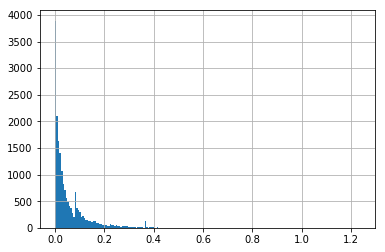

In [49]:
hehe['kl distance'].hist(bins=200)

In [42]:
hehe['kl distance'].median()

0.0261667686562274

In [47]:
hehe['kl distance'].quantile(0.975)

0.2906845791282257

In [48]:
len(hehe)*.025

464.40000000000003